## init ##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# now can import drive files as usual files with the path like
# /content/drive/My Drive/location_of_the_file

Mounted at /content/drive


In [ ]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

DRIVE_INITIAL_PATH = r"/content/drive/My Drive/Data Mining"

OUR_PP_RECIPES_PATH = r"data/our_pp_recipes.csv"
OUR_PP_INTERACTIONS_PATH = r"data/our_pp_interactions.csv"

DATE_FORMAT = "%Y-%m-%d"
RAW_RECIPES_DATE_COLUMNS = ["submitted"]
RAW_INTERCATIONS_DATE_COLUMNS = ["date"]


def adapt_path_to_drive(original_path):
  return "/".join([DRIVE_INITIAL_PATH, original_path])

# for drive use
OUR_PP_RECIPES_PATH = adapt_path_to_drive(OUR_PP_RECIPES_PATH)
OUR_PP_INTERACTIONS_PATH = adapt_path_to_drive(OUR_PP_INTERACTIONS_PATH)


### Helper ###

In [ ]:
def format_date_column(df, column_to_format, date_format=DATE_FORMAT):
  df[column_to_format] = pd.to_datetime(df[column_to_format], format=date_format)
  return df

### Boolean Functions ###

#### Submit analysis ####

In [ ]:
DF_RECIPES = pd.read_csv(OUR_PP_RECIPES_PATH, encoding="utf-8")
DF_INTERACTIONS = pd.read_csv(OUR_PP_INTERACTIONS_PATH, encoding="utf-8")


In [ ]:
def get_year_month_counts(df, date_col):
  df = format_date_column(df, date_col) 
  df["year-month"] = df[date_col].dt.year.astype("str") + "-" + df[date_col].dt.month.apply(lambda x: '{:02}'.format(x))
  counts_df = df.groupby("year-month").count()["recipe_id"].reset_index()
  return counts_df.rename(columns={"recipe_id":"total_per_month"})

ALL_RECIPES_PER_MONTH = get_year_month_counts(DF_RECIPES, "submitted")


def show_bool_analyzed_submitted_graphs(col_name, parameter_desc, linewidth=1.5, lim_percent=(0, 1), marker=False):
  questioned_per_month = get_year_month_counts(DF_RECIPES.loc[DF_RECIPES[col_name]], "submitted")
  per_month_stats = ALL_RECIPES_PER_MONTH.merge(questioned_per_month, how="left",
                                              on="year-month",suffixes=("_all", "_questioned"))
  per_month_stats = per_month_stats.fillna(0)
  per_month_stats["questioned_per_month_percentage"] = per_month_stats["total_per_month_questioned"] / per_month_stats["total_per_month_all"]
  per_month_stats["start_month_date"] = per_month_stats["year-month"].apply(lambda x: x + "-01")
  per_month_stats = format_date_column(per_month_stats, "start_month_date")

  if marker:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', linewidth=linewidth, marker=True)
  else:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', linewidth=linewidth)

  plt.title('{0} submitted per month'.format(parameter_desc))
  plt.xlabel("date")
  plt.ylabel("amount")

  plt.show()


  if marker:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle="solid", linewidth=linewidth, marker=True)
  else:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle="solid", linewidth=linewidth)

  plt.xlabel("date")
  plt.ylabel("relative amount")
  plt.title('{0} relative portion out of total submitted recipes per month'.format(parameter_desc))
  plt.ylim(lim_percent[0], lim_percent[1])

  plt.show()


####Interactions Analysis ####

In [ ]:
ALL_INTERACTIONS_PER_MONTH = get_year_month_counts(DF_INTERACTIONS, "date")


def show_bool_analyzed_interactions_graphs(col_name, parameter_desc, linewidth=1.5, lim_percent=(0, 1), marker=False):
  questioned_interactions = DF_RECIPES.loc[DF_RECIPES[col_name]].merge(DF_INTERACTIONS, how="inner", on="recipe_id")
  questioned_per_month = get_year_month_counts(questioned_interactions, "date")
  per_month_stats = ALL_INTERACTIONS_PER_MONTH.merge(questioned_per_month, how="left",
                                              on="year-month",suffixes=("_all", "_questioned"))
  per_month_stats = per_month_stats.fillna(0)
  per_month_stats["questioned_per_month_percentage"] = per_month_stats["total_per_month_questioned"] / per_month_stats["total_per_month_all"]
  per_month_stats["start_month_date"] = per_month_stats["year-month"].apply(lambda x: x + "-01")
  per_month_stats = format_date_column(per_month_stats, "start_month_date")

  if marker:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', linewidth=linewidth, marker=True)
  else:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', linewidth=linewidth)

  plt.title('interactions made with {0} per month'.format(parameter_desc))
  plt.xlabel("date")
  plt.ylabel("amount")

  plt.show()

  if marker:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle='solid', linewidth=linewidth, marker=True)
  else:
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle='solid', linewidth=linewidth)

  plt.xlabel("date")
  plt.ylabel("relative amount")
  plt.title("{0}'s interactions relative portion out of total interactions made per month".format(parameter_desc))
  plt.ylim(lim_percent[0], lim_percent[1])

  plt.show()


###Numbers Functions###

#### Submit Analysis####

In [ ]:
# get df and name of number column
# get steps_size, steps_amount - cur_min <= x < cur_max except the last which is cur_min <= x <= cur_max
# divide the data to steps_amount dfs - save in a map - key is the name of the range, value is the df
# run a version of show_analyzed_submitted_graphs that runs in bulks
# choose colors and make legend

def get_field_partition(df, col_name, min_value, step_size, steps_amount):
  d = {}
  col_series = df[col_name]
  for i in range(steps_amount):
    cur_min = min_value + i * step_size
    cur_max = cur_min + step_size
    cur_key = str(cur_min) + "-" + str(cur_max)
    if i == steps_amount - 1:
      cur_val = df.loc[(cur_min <= col_series) & (col_series <= cur_max)]
    else:
      cur_val = df.loc[(cur_min <= col_series) & (col_series < cur_max)]
    d[cur_key] = cur_val
  return d

def get_year_month_counts(df, date_col, counts_col_name="total_per_month"):
  df = format_date_column(df, date_col) 
  df["year-month"] = df[date_col].dt.year.astype("str") + "-" + df[date_col].dt.month.apply(lambda x: '{:02}'.format(x))
  counts_df = df.groupby("year-month").count()["recipe_id"].reset_index()
  return counts_df.rename(columns={"recipe_id":counts_col_name})

def get_per_month_stats(filtered_df, date_col_name, all_per_month_stats):
  questioned_per_month = get_year_month_counts(filtered_df, date_col_name)
  per_month_stats = all_per_month_stats.merge(questioned_per_month, how="left",
                                                on="year-month",suffixes=("_all", "_questioned"))
  per_month_stats = per_month_stats.fillna(0)
  per_month_stats["questioned_per_month_percentage"] = per_month_stats["total_per_month_questioned"] / per_month_stats["total_per_month_all"]
  per_month_stats["start_month_date"] = per_month_stats["year-month"].apply(lambda x: x + "-01")
  per_month_stats = format_date_column(per_month_stats, "start_month_date")
  return per_month_stats





In [ ]:
PP_RECIPES_DF = pd.read_csv(OUR_PP_RECIPES_PATH, encoding="utf-8")
PP_INTERACTIONS_DF = pd.read_csv(OUR_PP_INTERACTIONS_PATH, encoding="utf-8")
ALL_RECIPES_PER_MONTH = get_year_month_counts(PP_RECIPES_DF, "submitted")
ALL_INTERACTIONS_PER_MONTH = get_year_month_counts(PP_INTERACTIONS_DF, "date")



In [ ]:
def show_num_analyzed_submitted_graphs(df, col_name, parameter_desc, min_value, step_size, steps_amount,
                                       linewidth=1.5, lim_percent=(0, 1), marker=False):
  dfs_dicts = get_field_partition(df, col_name, min_value, step_size, steps_amount)
  questioned_dfs_per_month = {}
  colormap = plt.cm.viridis
  colors = [colormap(i) for i in np.linspace(0, 1,len(dfs_dicts))]

  for cur_key in dfs_dicts.keys():
    per_month_stats = get_per_month_stats(dfs_dicts[cur_key], "submitted", ALL_RECIPES_PER_MONTH)
    questioned_dfs_per_month[cur_key] = per_month_stats
  
  for (i ,cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    if marker:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', color=colors[i], label=cur_key, marker=True, linewidth=linewidth)
    else:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', color=colors[i], label=cur_key, linewidth=linewidth)
  

  plt.title('{0} submitted per month'.format(parameter_desc))
  plt.xlabel("date")
  plt.ylabel("amount")
  plt.legend()

  plt.show()

  for (i, cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    if marker:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle="solid", color=colors[i], label=cur_key, linewidth=linewidth, marker=True)
    else:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle="solid", color=colors[i], label=cur_key, linewidth=linewidth)


  plt.xlabel("date")
  plt.ylabel("relative amount")
  plt.title('{0} relative portion out of total submitted recipes per month'.format(parameter_desc))
  plt.ylim(lim_percent[0], lim_percent[1])
  plt.legend()

  plt.show()


#### Interactions Analysis####

In [ ]:
                                     
def show_num_analyzed_interactions_graphs(df, col_name, parameter_desc, min_value, step_size, steps_amount,
                                          linewidth=1.5, lim_percent=(0, 1), marker=False):
  dfs_dicts = get_field_partition(df, col_name, min_value, step_size, steps_amount)
  questioned_dfs_per_month = {}
  colormap = plt.cm.viridis
  colors = [colormap(i) for i in np.linspace(0, 1,len(dfs_dicts))]

  for cur_key in dfs_dicts.keys():
    cur_df = dfs_dicts[cur_key].merge(PP_INTERACTIONS_DF, how="inner", on="recipe_id")
    per_month_stats = get_per_month_stats(cur_df, "date", ALL_INTERACTIONS_PER_MONTH)
    questioned_dfs_per_month[cur_key] = per_month_stats
  
  for (i ,cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    if marker:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', color=colors[i], label=cur_key, marker=True, linewidth=linewidth)
    else:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', color=colors[i], label=cur_key, linewidth=linewidth)

  

  plt.title('interactions made with {0} per month'.format(parameter_desc))
  plt.xlabel("date")
  plt.ylabel("amount")
  plt.legend()
  plt.show()

  for (i, cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    if marker:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle='solid', color=colors[i], label=cur_key, marker=True, linewidth=linewidth)
    else:
      plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle='solid', color=colors[i], label=cur_key, linewidth=linewidth)


  per_month_stats.to_csv(adapt_path_to_drive("data/minutes_0_45_per_month.csv"), encoding="utf-8", index=False)
  plt.xlabel("date")
  plt.ylabel("relative amount")
  plt.title("{0}'s interactions relative portion out of total interactions made per month".format(parameter_desc))
  plt.ylim(lim_percent[0], lim_percent[1])
  plt.legend()

  plt.show()


## Submission & Interactions Volumes Checks ##

### minutes parameter ###

Checked 40 mins ranges and 20 mins ranges and not much changed
the ups and downs in summer and winter are mainly due to 1-21 range

**Main Range 1-181**

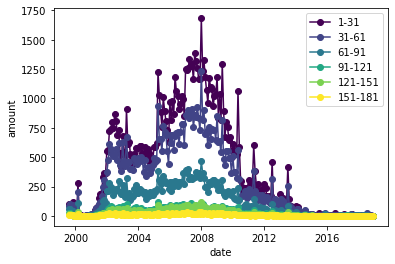

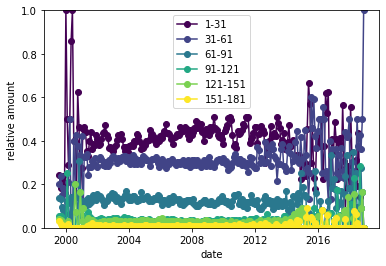

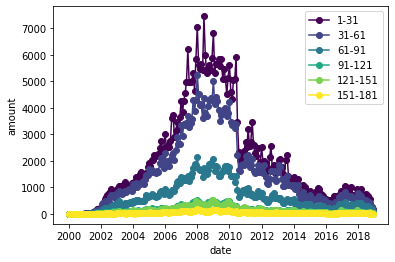

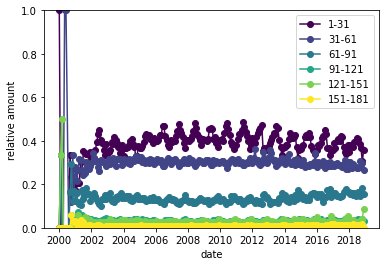

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "minutes", "Recipes within prepare time ranges", 1, 30, 6,
                                       linewidth=1.5, lim_percent=(0, 1), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "minutes", "Recipes within prepare time ranges", 1, 30, 6,
                                          linewidth=1.5, lim_percent=(0, 1), marker=False)

**edge range - 181 and above**

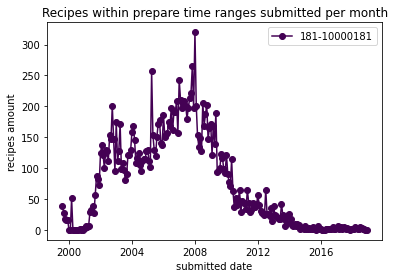

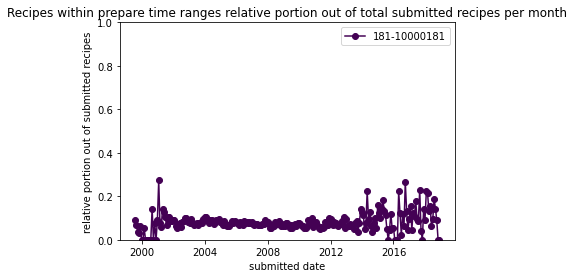

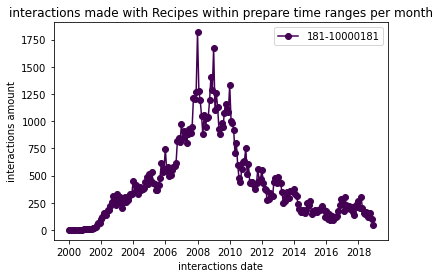

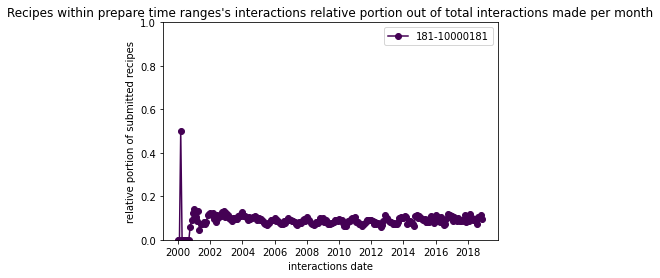

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "minutes", "Recipes within prepare time ranges", 181, 10000000, 1,
                                       linewidth=1.5, lim_percent=(0, 1), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "minutes", "Recipes within prepare time ranges", 181, 10000000, 1,
                                          linewidth=1.5, lim_percent=(0, 1), marker=False)

### number of steps parameter ###

tried 3,7 also. graphs looks different but the trend is the same

**Main Range 1-26**

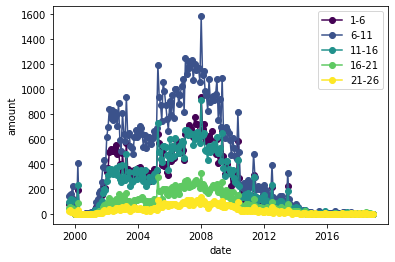

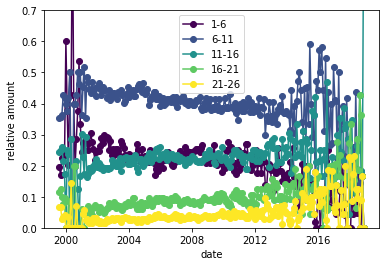

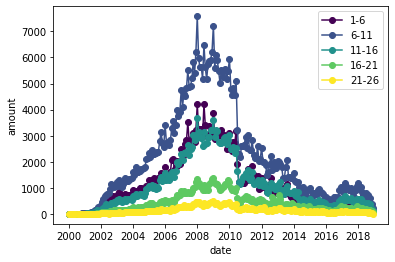

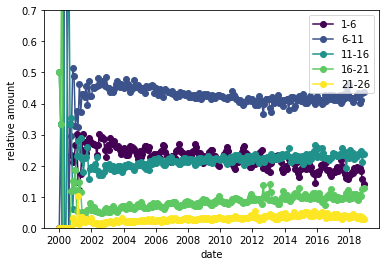

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "n_steps", "Recipes within steps numbers' ranges", 1, 5, 5,
                                       linewidth=1.5, lim_percent=(0, 0.7), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "n_steps", "Recipes within steps numbers' ranges", 1, 5, 5,
                                          linewidth=1.5, lim_percent=(0, 0.7), marker=False)

**edge range - 26 and above**

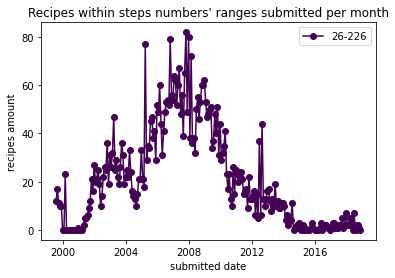

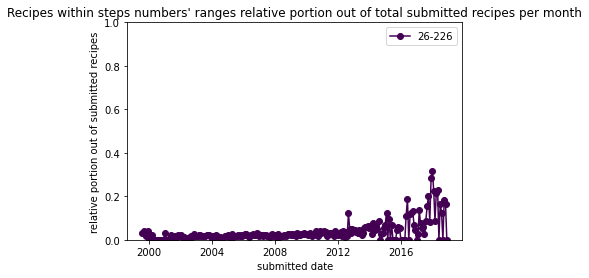

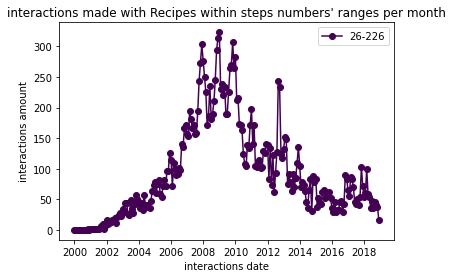

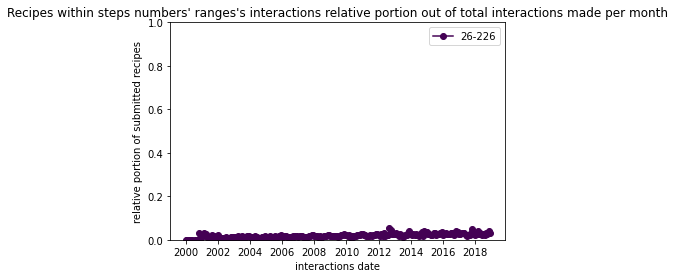

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "n_steps", "Recipes within steps numbers' ranges", 26, 200, 1,
                                       linewidth=1.5, lim_percent=(0, 1), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "n_steps", "Recipes within steps numbers' ranges", 26, 200, 1,
                                          linewidth=1.5, lim_percent=(0, 1), marker=False)

### number of ingredients parameter ###

tried also 6. not much different

**Main Range 1-21**

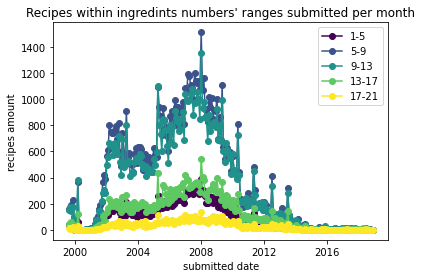

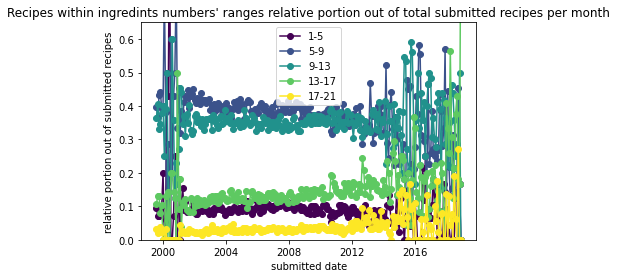

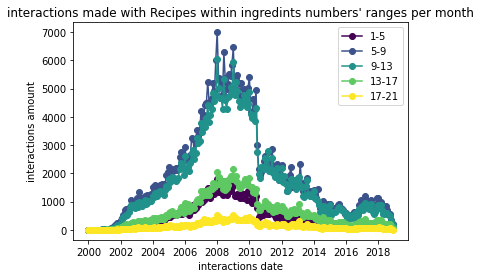

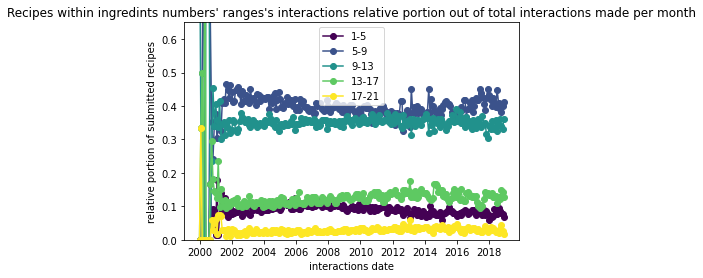

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "n_ingredients", "Recipes within ingredints numbers' ranges", 1, 4, 5,
                                       linewidth=1.5, lim_percent=(0, 0.65), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "n_ingredients", "Recipes within ingredints numbers' ranges", 1, 4, 5,
                                          linewidth=1.5, lim_percent=(0, 0.65), marker=False)

**edge range - 21 and above**

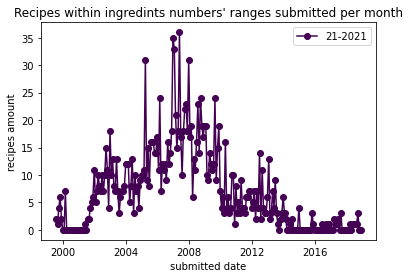

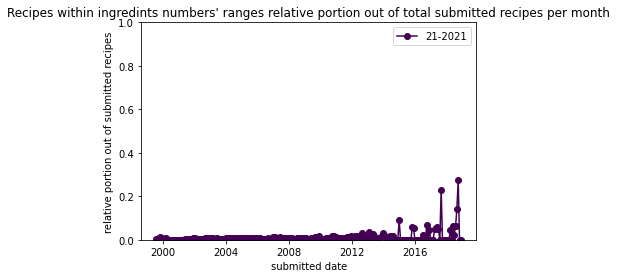

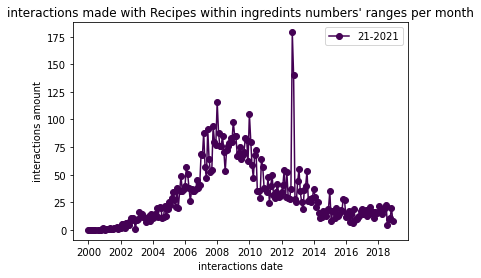

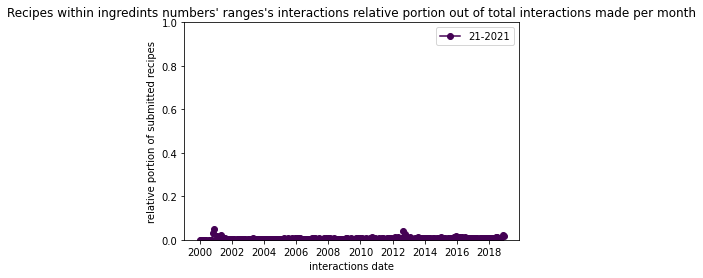

In [ ]:
show_num_analyzed_submitted_graphs(PP_RECIPES_DF, "n_ingredients", "Recipes within ingredints numbers' ranges", 21, 2000, 1,
                                       linewidth=1.5, lim_percent=(0, 1), marker=False)

show_num_analyzed_interactions_graphs(PP_RECIPES_DF, "n_ingredients", "Recipes within ingredints numbers' ranges", 21, 2000, 1,
                                          linewidth=1.5, lim_percent=(0, 1), marker=False)

## Sanity Check ##

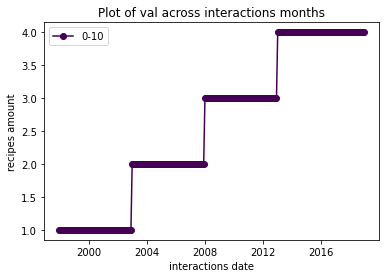

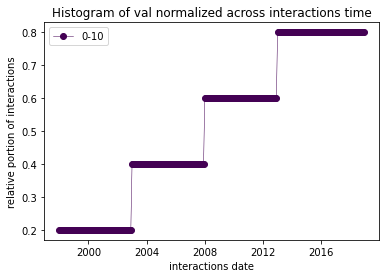

In [ ]:
df_all = pd.read_csv("all_basic.csv", encoding="utf-8")
all_per_month = get_year_month_counts(df_all, "date")
df_param = pd.read_csv("param_basic.csv", encoding="utf-8")

def to_check(df, col_name, min_value, step_size, steps_amount):
  dfs_dicts = get_field_partition(df, col_name, min_value, step_size, steps_amount)
  questioned_dfs_per_month = {}
  colormap = plt.cm.viridis
  colors = [colormap(i) for i in np.linspace(0, 1,len(dfs_dicts))]

  for cur_key in dfs_dicts.keys():
    cur_df = dfs_dicts[cur_key]
    per_month_stats = get_per_month_stats(cur_df, "date", all_per_month)
    questioned_dfs_per_month[cur_key] = per_month_stats
  
  for (i ,cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["total_per_month_questioned"], linestyle='solid', color=colors[i], label=cur_key, marker=False, linewidth=1)
  

  plt.title('Plot of {0} across interactions months'.format(col_name))
  plt.xlabel("interactions date")
  plt.ylabel("recipes amount")
  plt.legend()
  plt.show()

  for (i, cur_key) in enumerate(questioned_dfs_per_month.keys()):
    per_month_stats = questioned_dfs_per_month[cur_key]
    plt.plot_date(x=per_month_stats["start_month_date"], y=per_month_stats["questioned_per_month_percentage"], linestyle='solid', color=colors[i], label=cur_key, linewidth=1, marker=False)


  plt.xlabel("interactions date")
  plt.ylabel("relative portion of interactions")
  plt.title('Histogram of {0} normalized across interactions time'.format(col_name))
  plt.legend()

  plt.show()


#df_param["date"][0]

to_check(df_param, "val", 0, 10, 1)

Outcome of the check: These are correct graphs correct Graphs

## Seasonal Tredns##

In [ ]:
def present_by_seasons(filtered_df, date_col_name, all_per_month_df, plot_name, limy=(0,1)):
  seasons = ["winter", "summer"]
  colors = ["blue", "red"]
  per_month_stats = get_per_month_stats(filtered_df, date_col_name, all_per_month_df)
  month_to_season = {1: "winter", 2: "winter", 3: "spring", 4: "spring", 5: "spring", 6: "summer", 7: "summer", 8: "summer", 9: "autumn", 10: "autumn", 11: "autumn", 12: "winter"}
  per_month_stats["season"] = per_month_stats.start_month_date.dt.month.map(month_to_season)

  for (i, season) in enumerate(seasons):
    filtered_season_records = per_month_stats.loc[per_month_stats["season"] == season]
    plt.plot_date(x=filtered_season_records["start_month_date"], y=filtered_season_records["total_per_month_questioned"], linestyle='solid', color=colors[i],
                  label=season, linewidth=1) # marker=False
  

  #plt.title('Plot of {0} across interactions time per season'.format(plot_name))
  plt.xlabel("interactions date")
  plt.ylabel("recipes amount")
  plt.legend()
  plt.show()

  for (i, season) in enumerate(seasons):
    filtered_season_records = per_month_stats.loc[per_month_stats["season"] == season]
    plt.plot_date(x=filtered_season_records["start_month_date"], y=filtered_season_records["questioned_per_month_percentage"], linestyle='solid', color=colors[i],
                  label=season, linewidth=1)


  plt.xlabel("interactions date")
  plt.ylabel("relative amount")
  plt.ylim(limy[0], limy[1])
  plt.title('Plot of {0} normalized across interactions time per season'.format(plot_name))
  plt.legend()

  plt.show()



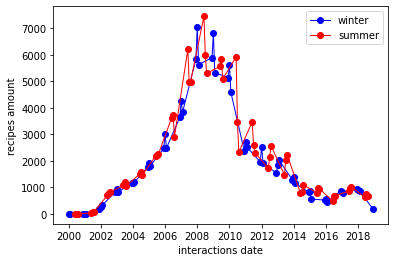

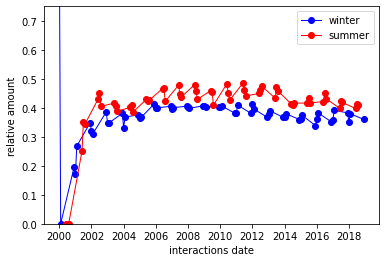

In [ ]:
df_minutes_till_30 = PP_RECIPES_DF.loc[(PP_RECIPES_DF.minutes <= 30) & (PP_RECIPES_DF.minutes >= 1)].merge(PP_INTERACTIONS_DF, how="inner", on="recipe_id")
present_by_seasons(df_minutes_till_30, "date", ALL_INTERACTIONS_PER_MONTH, "minutes till 30", limy=(0, 0.75))

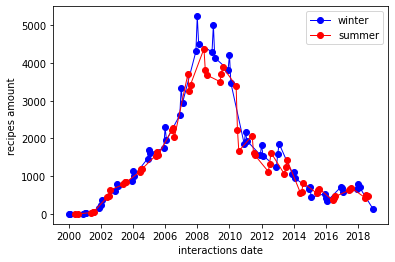

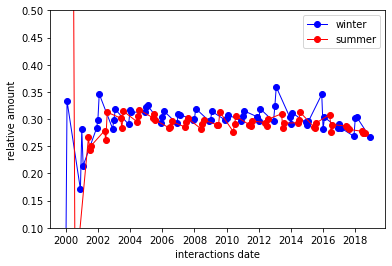

In [ ]:
df_minutes_till_30_60 = PP_RECIPES_DF.loc[(PP_RECIPES_DF.minutes <= 60) & (PP_RECIPES_DF.minutes > 30)].merge(PP_INTERACTIONS_DF, how="inner", on="recipe_id")
present_by_seasons(df_minutes_till_30_60, "date", ALL_INTERACTIONS_PER_MONTH, "minutes till 30", limy=(0.1, 0.5))

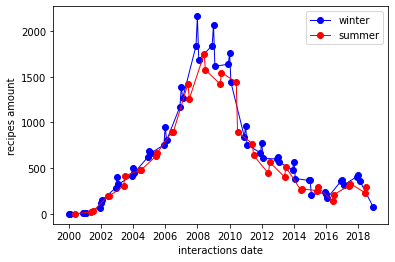

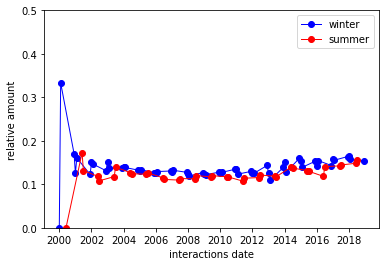

In [ ]:
df_minutes_till_60_90 = PP_RECIPES_DF.loc[(PP_RECIPES_DF.minutes <= 90) & (PP_RECIPES_DF.minutes >60)].merge(PP_INTERACTIONS_DF, how="inner", on="recipe_id")
present_by_seasons(df_minutes_till_60_90, "date", ALL_INTERACTIONS_PER_MONTH, "minutes till 30", limy=(0, 0.5))

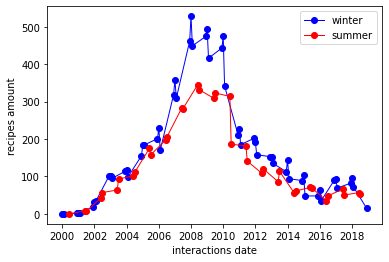

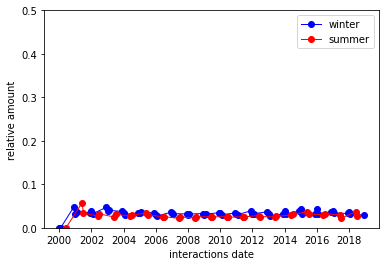

In [ ]:
df_minutes_till_90_120 = PP_RECIPES_DF.loc[(PP_RECIPES_DF.minutes <= 120) & (PP_RECIPES_DF.minutes >90)].merge(PP_INTERACTIONS_DF, how="inner", on="recipe_id")
present_by_seasons(df_minutes_till_90_120, "date", ALL_INTERACTIONS_PER_MONTH, "minutes till 30", limy=(0, 0.5))

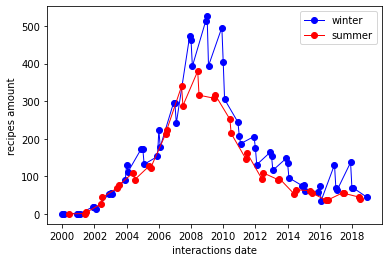

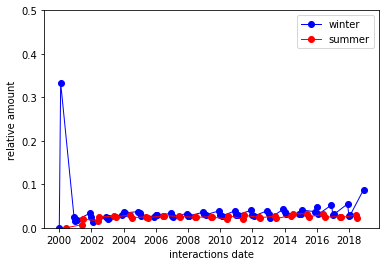

In [ ]:
df_minutes_till_120_150 = PP_RECIPES_DF.loc[(PP_RECIPES_DF.minutes <= 150) & (PP_RECIPES_DF.minutes >120)].merge(PP_INTERACTIONS_DF, how="inner", on="recipe_id")
present_by_seasons(df_minutes_till_120_150, "date", ALL_INTERACTIONS_PER_MONTH, "minutes till 30", limy=(0, 0.5))

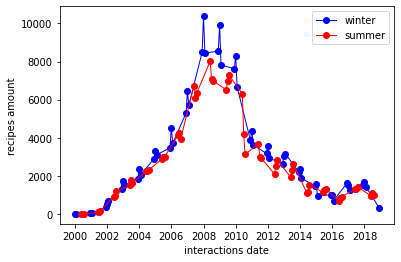

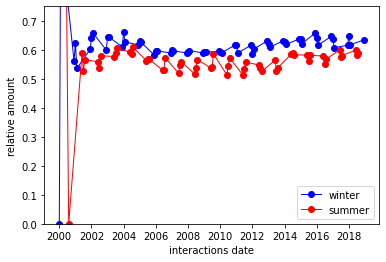

In [ ]:
df_minutes_above_30 = PP_RECIPES_DF.loc[(PP_RECIPES_DF.minutes >30)].merge(PP_INTERACTIONS_DF, how="inner", on="recipe_id")
present_by_seasons(df_minutes_above_30, "date", ALL_INTERACTIONS_PER_MONTH, "minutes till 30", limy=(0, 0.75))